In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

from PIL import Image

from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from torchvision.transforms import v2

In [49]:
# Load in ResNet Model, but we need to take into account
# the fact that we need to incorporate the ancillary data

# We combine the model because we have different features that we need to utilize
class CombinedModel(nn.Module):
    def __init__(self, num_preds=6):
        super(CombinedModel, self).__init__()
        
        resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
        # Get everything EXCEPT for the last layer.
        # Why? The last layer is responsible for the predictions, and we have a regression problem right now
        # of which the model needs to take into account the ancillary data provided.
        self.resnet_features = nn.Sequential(*list(resnet.children())[:-1]) 
    
        # define the ancillary part of the model
        self.ancillary_net = nn.Sequential(
            nn.Linear(163, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
        )
        
        # define fully connected layer (the "last part" after flattening everything)
        self.fc = nn.Sequential(
            nn.Linear(528, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_preds)
        )

    # Redefine the forward function so that we can concatenate the ancillary data and the image data together
    def forward(self, image, ancillary):
        x_image = self.resnet_features(image)
        
        # we need to end up flattening the image
        x_image = x_image.view(x_image.size(0), -1)
        
        # process the ancillary or other data associated with each image
        x_ancillary = self.ancillary_net(ancillary)
        
        # combine the features together
        ret_x = torch.cat((x_image, x_ancillary), dim=1)

        # put them into the fully connected part of the model
        ret_x = self.fc(ret_x)
        
        return ret_x
        

net = CombinedModel()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [50]:
# Load in the device into the gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
net = net.to(device)

cuda:0


In [51]:
# Create a way to load in images properly
REG_FACTOR = 255.0
NUM_CHANNELS = 3

ANCILLARY_COLUMNS = 163
PREDICTOR_COLUMNS = 6
TOTAL_COLUMNS = 1 + ANCILLARY_COLUMNS + PREDICTOR_COLUMNS

min_max_scalers = np.empty(TOTAL_COLUMNS, dtype=object) # create an array to get the scalers
for i in range(TOTAL_COLUMNS):
    min_max_scalers[i] = MinMaxScaler()
    
class CustomDataset(Dataset):
    # initialize the csv file, and THEN normalize it
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.norm_data_frame = self.data_frame.copy()
        self.root_dir = root_dir
        self.transform = transform
        
        self.normalize_data_frame()
 
    def __len__(self): # probably not used right now, but good helper function just in case
        return len(self.data_frame)
    
    # normalizing data frame using the scalers provided
    def normalize_data_frame(self):
        for i, column in enumerate(self.data_frame.columns):
            if i == 0: continue
            column_data = self.data_frame[[column]]
            self.norm_data_frame[column] = min_max_scalers[i].fit_transform(column_data).flatten()

    # override the get_item function as we need to match the images to the csv file data
    def __getitem__(self, idx):
        # get the image first, because we want to match it to what we have in the CSV file
        img_name = self.root_dir + '/' + str(self.norm_data_frame.iloc[idx, 0]) + ".jpeg"
        image = Image.open(img_name).convert('RGB')
        
        # Convert the data frame to numpy to get the array of values
        label = self.norm_data_frame.iloc[idx].to_numpy()
        
        # this is always going to run, but as a sanity check for us
        if self.transform:
            image = self.transform(image)
            
            
        return image, label

In [52]:
# Transform function for normalization purposes
transform = transforms.Compose([
    transforms.Resize((224, 224)), # we have to resize it to (224, 224) because ResNet demands that we do
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load initial training datasets and testing datasets
# Note for marker: put the path to the csv file for train and test under csv_file, and the path to the images under the root directory (this is so
# that we can load both at the same time!)
train_dataset = CustomDataset(csv_file="/kaggle/input/cs-480-2024-spring/data/train.csv", 
                              root_dir="/kaggle/input/cs-480-2024-spring/data/train_images",
                              transform=transform)
test_dataset = CustomDataset(csv_file="/kaggle/input/cs-480-2024-spring/data/test.csv",
                             root_dir="/kaggle/input/cs-480-2024-spring/data/test_images",
                             transform=transform)

# Split the training dataset into training and validation subsets.
train_subset, validation_subset = random_split(train_dataset, [0.8, 0.2])

# Shuffling is not needed for the validation and testing loaders.
train_loader = DataLoader(dataset=train_subset, batch_size=64, shuffle=True)
validation_loader = DataLoader(dataset=validation_subset, batch_size=64)
test_loader = DataLoader(dataset=test_dataset, batch_size=64)

# train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [53]:
# Check the shapes for the train loader, sanity check for us mainly
for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels: {labels.shape}")
    break # Break after only one iteration (check the shapes to correspond properly)

Batch of images shape: torch.Size([64, 3, 224, 224])
Batch of labels: torch.Size([64, 170])


In [54]:
# mean square loss needed for regression
criterion = nn.MSELoss()
# optimizer = optim.SGD(net.parameters(), lr=1e-4, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min')
# print("Net parameters: ", len(list(net.parameters())))

In [55]:
NUMBER_OF_EPOCHS = 15

train_losses = np.zeros(NUMBER_OF_EPOCHS)
validation_losses = np.zeros(NUMBER_OF_EPOCHS)

In [56]:
for epoch in range(NUMBER_OF_EPOCHS):
    train_running_loss = 0.0
    validation_running_loss = 0.0
    
    # Train on the training set FIRST
    net.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        # Keep in mind, the ancillary data is the first 164 values
        # The 6 last labels are the predictor values we are looking for
        ancillary_values = labels[:, 1:ANCILLARY_COLUMNS+1].to(torch.float32)
        predictors = labels[:, ANCILLARY_COLUMNS+1:].to(torch.float32)

        outputs = net(inputs, ancillary_values)

        loss = criterion(outputs, predictors)
        loss.backward() # Backpropagation!

        optimizer.step()

        train_running_loss += loss.item() * images.size(0)
    
    # Evaluate the overall loss within the epoch for the training dataset.
    train_epoch_loss = train_running_loss / len(train_loader.dataset)
    train_losses[epoch] = train_epoch_loss
    
    print(f"Finished Epoch {epoch+1} in testing. Go through validation...")
    
    net.eval()
    # Validation set: we don't need to do backpropagation as we are evaluating the loss as we go along.
    with torch.no_grad():
        for i, data in enumerate(validation_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            ancillary_values = labels[:, 1:ANCILLARY_COLUMNS+1].to(torch.float32)
            predictors = labels[:, ANCILLARY_COLUMNS+1:].to(torch.float32)

            outputs = net(inputs, ancillary_values)
            loss = criterion(outputs, predictors)

            validation_running_loss += loss.item() * images.size(0)
    
    validation_epoch_loss = validation_running_loss / len(validation_loader.dataset)
    validation_losses[epoch] = validation_epoch_loss
    
    scheduler.step(validation_epoch_loss)
    
    print(f"Finished Epoch {epoch+1} in validation in testing. Print out the losses.")
    print(f"Epoch: {epoch+1}/{NUMBER_OF_EPOCHS}, Training Loss: {train_epoch_loss:.4f}, Validation Loss: {validation_epoch_loss:.4f}")

Finished Epoch 1 in testing. Go through validation...
Finished Epoch 1 in validation in testing. Print out the losses.
Epoch: 1/15, Training Loss: 0.0810, Validation Loss: 0.0376
Finished Epoch 2 in testing. Go through validation...
Finished Epoch 2 in validation in testing. Print out the losses.
Epoch: 2/15, Training Loss: 0.0212, Validation Loss: 0.0295
Finished Epoch 3 in testing. Go through validation...
Finished Epoch 3 in validation in testing. Print out the losses.
Epoch: 3/15, Training Loss: 0.0192, Validation Loss: 0.0203
Finished Epoch 4 in testing. Go through validation...
Finished Epoch 4 in validation in testing. Print out the losses.
Epoch: 4/15, Training Loss: 0.0183, Validation Loss: 0.0269
Finished Epoch 5 in testing. Go through validation...
Finished Epoch 5 in validation in testing. Print out the losses.
Epoch: 5/15, Training Loss: 0.0191, Validation Loss: 0.0238
Finished Epoch 6 in testing. Go through validation...
Finished Epoch 6 in validation in testing. Print ou

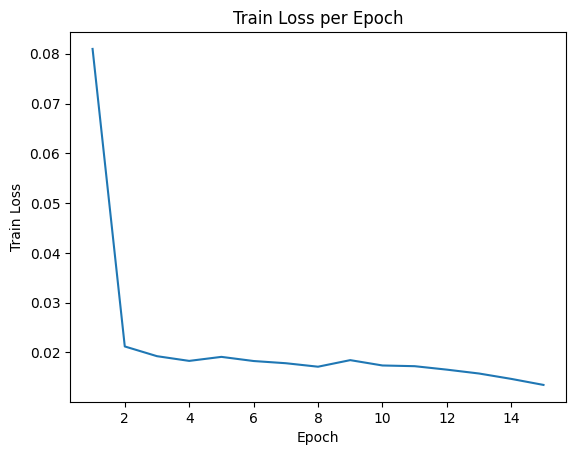

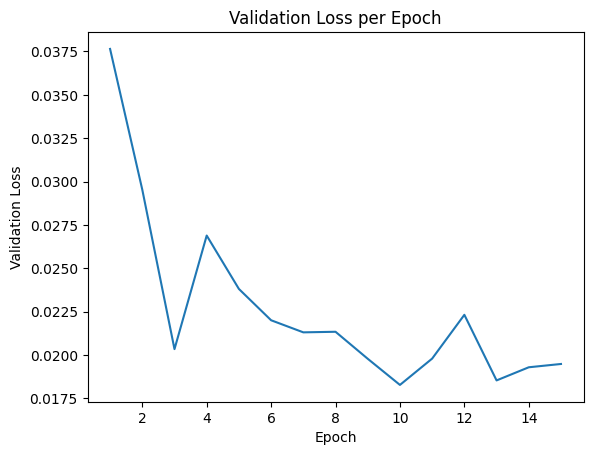

In [57]:
# Map it onto a graph, use it for the sake of the report and for our testing purposes!
num_epochs = [None] * NUMBER_OF_EPOCHS

for i in range(NUMBER_OF_EPOCHS):
    num_epochs[i] = i + 1
    
plt.plot(num_epochs, train_losses)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss per Epoch')
plt.show()

plt.plot(num_epochs, validation_losses)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss per Epoch')
plt.show()

In [58]:
import csv

# There are actually 6 predictors. The thing to remember however is that 
# the ids shouldn't be normalized, because these identify the images!
preds = np.empty((0, 7))

net.eval()

with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        # Load the inputs (images) and the labels (which include the ancillary data)
        inputs, labels = data[0].to(device), data[1].to(device)
        ancillary_values = labels[:, 1:ANCILLARY_COLUMNS+1].to(torch.float32)
        outputs = net(inputs, ancillary_values)
        augmented_outputs = np.zeros((outputs.shape[0], outputs.shape[1] + 1)) # include the ids 
        # append the outputs to an array that we can write to a csv file
        for i in range(outputs.shape[0]):
            augmented_outputs[i, 0] = labels[i, 0]
            augmented_outputs[i, 1:] = outputs.cpu()[i]
            preds = np.append(preds, [augmented_outputs[i]], axis=0)

In [59]:
print("Preds: ", preds[:, ].shape)
print("Preds: ", preds[:, 163:169]) # once again, sanity check!

Preds:  (6391, 7)
Preds:  []


In [60]:
# get the test data, and append our results to the column data
column_data = np.zeros((0, 6391))
for i in range(0, preds.shape[1]):
    if i == 0: continue
    removed_id_column_data = [preds[:, i]]

    # SCALE IT BACK! Since we normalized it between 0 and 1, we need to translate it back to what we had before.
    print("Scalars: ", min_max_scalers[ANCILLARY_COLUMNS+i].inverse_transform(removed_id_column_data))
    inverted_transform = min_max_scalers[ANCILLARY_COLUMNS+i].inverse_transform(removed_id_column_data)
    column_data = np.append(column_data, min_max_scalers[ANCILLARY_COLUMNS+i].inverse_transform(removed_id_column_data), axis=0)

normalized_preds = np.zeros(preds.shape)

# put the ids in the right place
normalized_preds[:, 0] = preds[:, 0]

# put the column data back in
for i in range(0, column_data.shape[0]):
    normalized_preds[:, i+1] = column_data[i]

# convert to dataframe so that we can convert it to a .csv file
df = pd.DataFrame(normalized_preds)

df.iloc[:, 0] = df.iloc[:, 0].astype(int)
    
headerList = ["id", "X4", "X11", "X18", "X26", "X50", "X3112"]
df.to_csv("/kaggle/working/predictions_l1.csv", header=headerList, index=False)

Scalars:  [[1.06352364 0.98886903 0.9032525  ... 1.07415523 1.04971669 0.93746074]]
Scalars:  [[146.89806309 152.66562827 150.23273232 ... 145.67139451 141.48016302
  151.04572523]]
Scalars:  [[19711.64531479 19699.85613539 19699.37826627 ... 19711.64755883
  19711.25105179 19699.0316611 ]]
Scalars:  [[3590.34325967 3465.94410149 3455.85583533 ... 3629.12062016
  3635.4615044  3454.59488123]]
Scalars:  [[15.12373867 14.69547442 14.78952176 ... 15.19186126 15.24622816
  14.83693374]]
Scalars:  [[404994.75121432 399275.04445307 398170.5790238  ... 402114.03015215
  401453.87583341 398403.62772189]]
